<a href="https://colab.research.google.com/github/JohanSantanaGalvanJob/Modeling-Earthquake-Damage/blob/main/Modeling_Earthquake_Damage_JohanSantanaGalv%C3%A1n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Johan Santana Galván

Importamos todas las librerías que vamos a necesitar

In [1]:
!pip install lazypredict

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.neighbors
from scipy import cluster
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, TimeSeriesSplit, GridSearchCV
import lazypredict
from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier
import pickle

Nos traemos nuestros conjuntos de datos desde Github

In [3]:
df_labels = pd.read_csv("https://raw.githubusercontent.com/JohanSantanaGalvanJob/Modeling-Earthquake-Damage/main/train_labels.csv")
df_train = pd.read_csv("https://raw.githubusercontent.com/JohanSantanaGalvanJob/Modeling-Earthquake-Damage/main/train_values.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/JohanSantanaGalvanJob/Modeling-Earthquake-Damage/main/test_values.csv")

Vamos a ver un poco cómo es nuestro conjunto de datos de entrenamiento, vamos a unir df_train con df_labels y hacer un primer filtrado rápido de los mismos.

In [4]:
common_columns = ['building_id']
df_train = pd.merge(df_train, df_labels, on=common_columns)
df_train.head(6)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3
5,333020,8,558,6089,2,10,9,5,t,r,...,0,0,0,0,0,0,0,0,0,2


In [5]:
df_train.shape

(260601, 40)

In [6]:
df_train.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,...,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00
mean,525675.48,13.90,701.07,6257.88,2.13,26.54,8.02,5.43,0.09,0.76,...,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,2.24
std,304545.00,8.03,412.71,3646.37,0.73,73.57,4.39,1.92,0.28,0.43,...,0.18,0.09,0.03,0.02,0.03,0.01,0.01,0.01,0.07,0.61
min,4.00,0.00,0.00,0.00,1.00,0.00,1.00,2.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,261190.00,7.00,350.00,3073.00,2.00,10.00,5.00,4.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,525757.00,12.00,702.00,6270.00,2.00,15.00,7.00,5.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
75%,789762.00,21.00,1050.00,9412.00,2.00,30.00,9.00,6.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
max,1052934.00,30.00,1427.00,12567.00,9.00,995.00,100.00,32.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,3.00


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [8]:
df_train

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0,0,0,0,0,0,0,0,2
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0,0,0,0,0,0,0,0,3
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0,0,0,0,0,0,0,0,2


In [9]:
# We will check if there are any null values in this dataset.
null_values = df_train.isnull().sum()
null_values

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

No tenemos valores null por lo que no habrá que borrarlos. Ahora lo que haremos será borrar la primera columna de building_id ya que no nos es relevante para nuestro modelo.

In [10]:
df_train = df_train.drop(columns=['building_id'], axis=1)

Ahora debemos categorizar aquellas columnas que no sean valores continuos

In [11]:
df_train['land_surface_condition'] = pd.factorize(df_train['land_surface_condition'])[0]
df_train['foundation_type'] = pd.factorize(df_train['foundation_type'])[0]
df_train['roof_type'] = pd.factorize(df_train['roof_type'])[0]
df_train['ground_floor_type'] = pd.factorize(df_train['ground_floor_type'])[0]
df_train['other_floor_type'] = pd.factorize(df_train['other_floor_type'])[0]
df_train['position'] = pd.factorize(df_train['position'])[0]
df_train['plan_configuration'] = pd.factorize(df_train['plan_configuration'])[0]
df_train['legal_ownership_status'] = pd.factorize(df_train['legal_ownership_status'])[0]

Asimismo, procederemos a crear un mapa de correlación para poder ver cómo son nuestros datos y valorar qué columnas borrar y cuáles no.

<Axes: >

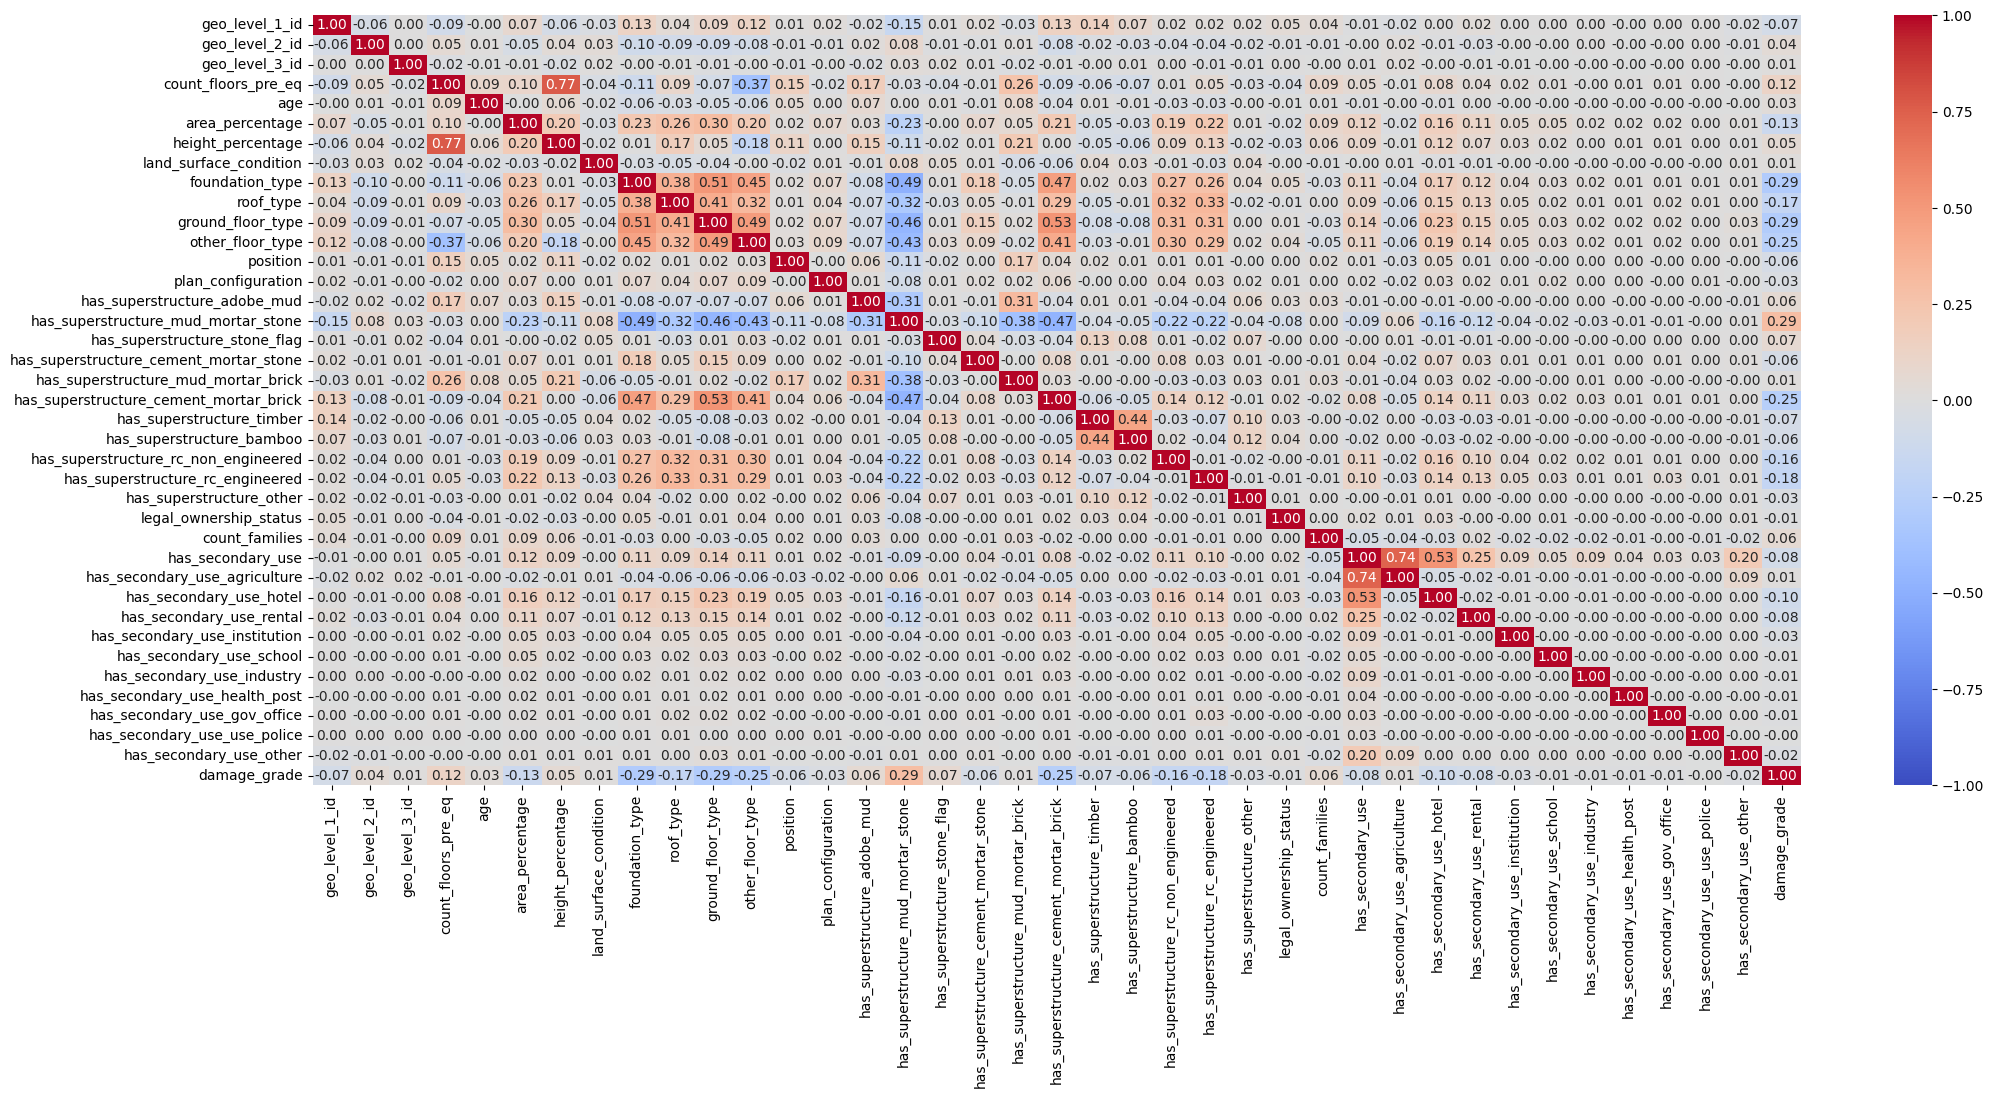

In [12]:
cor = df_train.corr()
plt.figure(figsize=(24 , 10))
sns.heatmap(cor , vmin = -1 , vmax = 1 ,fmt=".2f", cmap = "coolwarm" , annot= True)

Vemos que realmente no hay casi ninguna columna que esté muy relacionada. Así que solamente borraré has_secondary_use_agriculture ya que tiene un 0.74 de correlacióm, siendo la más notable de todos los datos.

In [13]:
df_train = df_train.drop(columns=['has_secondary_use_agriculture'], axis=1)

Ahora sí, tenemos todos los valores que necesitamos para nuestro entrenamiento. Ahora procederemos a hacer el dendograma.

Distancia Media	 2916.99


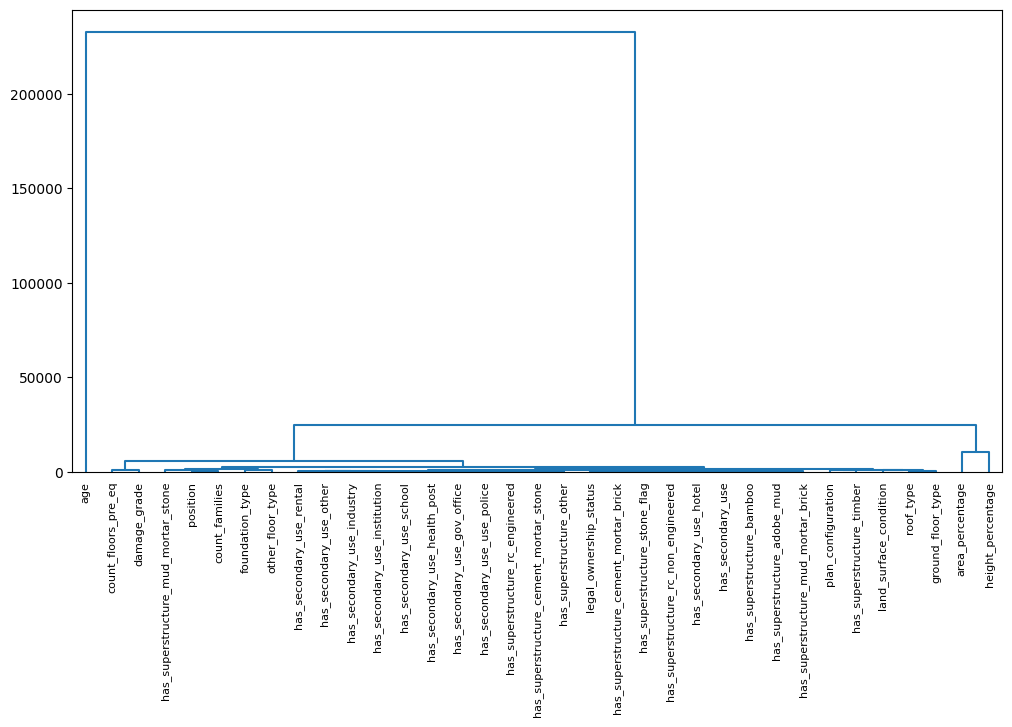

In [14]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
X_dist = df_train.drop(["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"], axis=1)
D = dist.pairwise(X_dist.T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

plt.figure(figsize=(12,6))
threshold_2 = 7
clusters = cluster.hierarchy.linkage(D, method='complete')
cluster.hierarchy.dendrogram(clusters, color_threshold=threshold_2, labels=X_dist.columns.to_list(), leaf_rotation=90)
plt.show()

Aunque no se puede ver extremadamente bien, podemos valorar que en dendograma, tenemos age como la columna menos relacionada, seguido de area_percentage y height_percentage. En cuanto al resto de columnas, realmente están todas muy relacionadas tal y como vimos en la matriz de correlación.

Ahora me interesa saber cuántos datos hay de damage grade 1, 2 y 3. Por lo que estableceré una gráfica para verlo.

<Axes: >

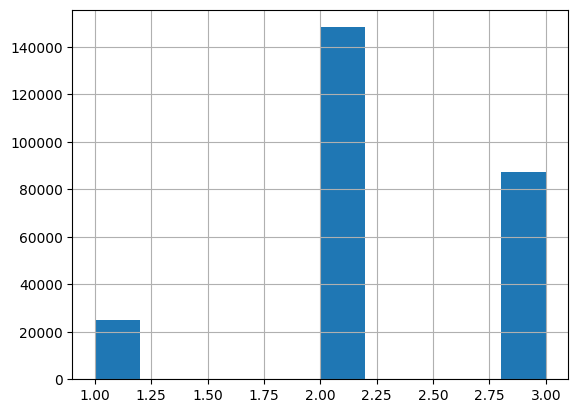

In [15]:
df_train['damage_grade'].hist()

Tenemos muchos valores descompensados. De 1 tenemos un poco más de 20000, de 2 tenemos +140000, y de 3 tenemos más de 80000. Por una cuestión de limitación, deberé equiparar todas a la máxima cantidad de valores de 1 posibles para así que los 3 estén al mismo nivel y por lo tanto el modelo no escoja más del valor 2 que del resto.

In [16]:
# Resetea los índices para que sean secuenciales
df_train.reset_index(drop=True, inplace=True)

In [17]:
df_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,487,12198,2,30,6,5,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,8,900,2812,2,10,8,7,1,0,0,...,0,0,0,0,0,0,0,0,0,2
2,21,363,8973,2,10,5,5,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,22,418,10694,2,10,6,5,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,11,131,1488,3,30,8,9,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1335,1621,1,55,6,3,2,0,0,...,0,0,0,0,0,0,0,0,0,2
260597,17,715,2060,2,0,6,5,0,0,0,...,0,0,0,0,0,0,0,0,0,3
260598,17,51,8163,3,55,6,7,0,0,1,...,0,0,0,0,0,0,0,0,0,3
260599,26,39,1851,2,10,14,6,0,0,2,...,0,0,0,0,0,0,0,0,0,2


In [18]:
print(df_train['damage_grade'].value_counts()[1])
print(df_train['damage_grade'].value_counts()[2])
print(df_train['damage_grade'].value_counts()[3])

25124
148259
87218


Vamos a tomar los 25124 valores para nuestro entrenamiento de datos. Hay que notar que al sumar los 3 valores da 260601 y esto nos indica que, al menos en esta columna (la cual va a ser nuestra y), no hay valores extraños ni nulos.

In [19]:

total_values = 25124

df_damage_grade_1 = df_train[df_train['damage_grade'] == 1].head(total_values)
df_damage_grade_2 = df_train[df_train['damage_grade'] == 2].head(total_values)
df_damage_grade_3 = df_train[df_train['damage_grade'] == 3].head(total_values)

df_train = pd.concat([df_damage_grade_1, df_damage_grade_2, df_damage_grade_3])


In [20]:
df_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
7,20,323,12236,2,0,8,6,0,1,1,...,0,0,0,0,0,0,0,0,0,1
9,26,886,994,1,0,13,4,0,2,0,...,0,0,0,0,0,0,0,0,0,1
36,13,305,5956,2,0,9,8,0,0,1,...,0,0,0,0,0,0,0,0,0,1
45,7,157,5265,1,5,11,3,2,2,2,...,0,1,0,0,0,0,0,0,0,1
49,26,762,742,1,0,15,3,2,3,2,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74671,4,571,11368,2,25,8,5,0,0,0,...,0,0,0,0,0,0,0,0,0,3
74672,4,1389,7957,3,40,8,6,0,0,1,...,0,0,0,0,0,0,0,0,0,3
74676,17,876,8597,2,25,17,5,0,0,0,...,0,0,0,0,0,0,0,0,0,3
74678,10,1140,2466,2,25,6,5,0,0,1,...,0,0,0,0,0,0,0,0,0,3


Vamos a proceder a realizar un Kbest de las características ahora que tenemos un poco más de criterio y así ver si esas características son buenas o no.

In [21]:
y= df_train['damage_grade']

In [22]:
for i in range(1, 15, 1):
  selector = SelectKBest(score_func=f_classif, k=i)
  X_new = selector.fit_transform(df_train, y)

  selected_columns = df_train.columns[selector.get_support()]

  print("Características seleccionadas de la iteración:" + str(i))
  print(str(selected_columns) + "\n")

Características seleccionadas de la iteración:1
Index(['damage_grade'], dtype='object')

Características seleccionadas de la iteración:2
Index(['has_superstructure_mud_mortar_stone', 'damage_grade'], dtype='object')

Características seleccionadas de la iteración:3
Index(['foundation_type', 'has_superstructure_mud_mortar_stone',
       'damage_grade'],
      dtype='object')

Características seleccionadas de la iteración:4
Index(['foundation_type', 'other_floor_type',
       'has_superstructure_mud_mortar_stone', 'damage_grade'],
      dtype='object')

Características seleccionadas de la iteración:5
Index(['foundation_type', 'ground_floor_type', 'other_floor_type',
       'has_superstructure_mud_mortar_stone', 'damage_grade'],
      dtype='object')

Características seleccionadas de la iteración:6
Index(['foundation_type', 'ground_floor_type', 'other_floor_type',
       'has_superstructure_mud_mortar_stone',
       'has_superstructure_cement_mortar_brick', 'damage_grade'],
      dtype='ob

In [23]:
selected_columns = ['geo_level_1_id', 'count_floors_pre_eq', 'area_percentage', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_cement_mortar_brick', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered','has_secondary_use_hotel','has_secondary_use_rental']

In [26]:
X = df_train[selected_columns]

Lo siguiente que haremos será dividir los datos en train, test y val para estudiar nuestro caso.

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Ahora que hemos hecho la división correspondiente, nos toca saber cuál podría ser el mejor modelo. En este caso haremos un lazy predict y veremos qué modelo tiene el mejor porcentaje.

In [29]:
X_train_subset = X_train.iloc[:15000]
X_val_subset = X_val.iloc[:15000]

y_train_subset = y_train.iloc[:15000]
y_val_subset = y_val.iloc[:15000]

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_subset, X_val_subset, y_train_subset, y_val_subset)

print(models)

 90%|████████▉ | 26/29 [02:34<00:27,  9.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 14
[LightGBM] [Info] Start training from score -1.107855
[LightGBM] [Info] Start training from score -1.096215
[LightGBM] [Info] Start training from score -1.091835


100%|██████████| 29/29 [02:35<00:00,  5.35s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.65               0.65    None      0.65   
AdaBoostClassifier                 0.63               0.63    None      0.63   
RandomForestClassifier             0.62               0.62    None      0.62   
ExtraTreesClassifier               0.62               0.62    None      0.61   
BaggingClassifier                  0.61               0.61    None      0.61   
DecisionTreeClassifier             0.60               0.60    None      0.60   
ExtraTreeClassifier                0.60               0.60    None      0.60   
LabelSpreading                     0.60               0.60    None      0.60   
KNeighborsClassifier               0.60               0.60    None      0.59   
LabelPropagation                   0.60               0.60    None      0.60   
SVC                                0.59 

Por una cuestión de potencia del colab, no he puesto todos los valores del conjunto de datos, sino que me he limitado a 15000 valores. Finalmente parece que el mejor modelo es LGBM Classifier con un 0.65 de precisión.

In [30]:
def classification_report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("Mean validation accuracy: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("")

In [31]:
lgbm = LGBMClassifier(force_row_wise=True)

Vamos a establecer una serie de valores a LGBM para que pueda ir probando diferentes combinaciones. A mayor número de combinaciones, más tardará el modelo.

In [32]:
# Parámetros de LightGBM
param_lgbm = {
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 7, 10],
}

In [33]:
# Como saber el número de combinaciones de parámetros que se van a ejecutar
num_combinations = 1
for param in param_lgbm:
    num_combinations *= len(param_lgbm[param])
print(f'El número total de combinaciones de parámetros en GridSearchCV es {num_combinations}')

El número total de combinaciones de parámetros en GridSearchCV es 9


Este es el entrenamiento del modelo en sí.

In [ ]:
grid_classif = GridSearchCV(estimator = lgbm, scoring='accuracy', param_grid= param_lgbm, cv = 5)
best_grid = grid_classif.fit(X_train[selected_columns], y_train)
pred_val_grid = best_grid.predict(X_val[selected_columns])
accuracy_val_grid = accuracy_score(y_val, pred_val_grid)
print("Precisión en el conjunto de validación con GridSearchCV:", accuracy_val_grid)

In [ ]:
grid_classif.cv_results_

In [36]:
classification_report(grid_classif.cv_results_, n_top = 5)

Model with rank: 1
Parameters: {'max_depth': 10, 'num_leaves': 40}
Mean validation accuracy: 0.664 (std: 0.003)

Model with rank: 2
Parameters: {'max_depth': 7, 'num_leaves': 40}
Mean validation accuracy: 0.664 (std: 0.003)

Model with rank: 3
Parameters: {'max_depth': 10, 'num_leaves': 30}
Mean validation accuracy: 0.663 (std: 0.003)

Model with rank: 4
Parameters: {'max_depth': 7, 'num_leaves': 30}
Mean validation accuracy: 0.663 (std: 0.002)

Model with rank: 5
Parameters: {'max_depth': 5, 'num_leaves': 30}
Mean validation accuracy: 0.662 (std: 0.003)



Hemos conseguido un 0.66 de acuracy aproximadamente. Ahora vamos a probar con RandomizedSearchCV a ver si obtenemos un mejor resultado.

In [37]:
param_dist = {
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 7, 10],
}

In [38]:
# Como saber el número de combinaciones de parámetros que se van a ejecutar
num_combinations = 1
for param in param_dist:
    num_combinations *= len(param_dist[param])
print(f'El número total de combinaciones de parámetros en RandomSearchCV es {num_combinations}')

El número total de combinaciones de parámetros en RandomSearchCV es 9


In [ ]:
random_classif = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
best_random = random_classif.fit(X_train[selected_columns], y_train)
pred_val_random = best_random.predict(X_val[selected_columns])
accuracy_val_random = accuracy_score(y_val, pred_val_random)
print("Precisión en el conjunto de validación con RandomSearch:", accuracy_val_random)

In [40]:
classification_report(random_classif.cv_results_, n_top = 5)

Model with rank: 1
Parameters: {'num_leaves': 40, 'max_depth': 10}
Mean validation accuracy: 0.664 (std: 0.003)

Model with rank: 2
Parameters: {'num_leaves': 40, 'max_depth': 7}
Mean validation accuracy: 0.664 (std: 0.003)

Model with rank: 3
Parameters: {'num_leaves': 30, 'max_depth': 10}
Mean validation accuracy: 0.663 (std: 0.003)

Model with rank: 4
Parameters: {'num_leaves': 30, 'max_depth': 7}
Mean validation accuracy: 0.663 (std: 0.002)

Model with rank: 5
Parameters: {'num_leaves': 30, 'max_depth': 5}
Mean validation accuracy: 0.662 (std: 0.003)



Hemos conseguido un aproximado de 0.66 también por lo que poco importa si elegimos uno u otro realmente. Ahora lo que haremos será probar con una máquina de vector de soporte hecha para problemas de clasificación. El SVC.

In [ ]:
SVM = SVC()

In [ ]:
param_svm = {
    'C': [0.5],
    'kernel': ['linear', 'rbf'],
}

In [ ]:
grid_classif_svm = GridSearchCV(estimator = SVM, scoring='accuracy', param_grid= param_svm, cv = 5)
best_grid_svm = grid_classif_svm.fit(X_train[selected_columns], y_train)
pred_val_grid_svm = best_grid_svm.predict(X_val[selected_columns])
accuracy_val_grid_svm = accuracy_score(y_val, pred_val_grid_svm)
print("Precisión en el conjunto de validación con GridSearchCV:", accuracy_val_grid_svm)

Precisión en el conjunto de validación con GridSearchCV: 0.5800331674958541


In [ ]:
random_classif = RandomizedSearchCV(SVM, param_distributions=param_svm, n_iter=3, cv=5, scoring='accuracy', random_state=42)
best_random = random_classif.fit(X_train[selected_columns], y_train)
pred_val_random = best_random.predict(X_val[selected_columns])
accuracy_val_random = accuracy_score(y_val, pred_val_random)
print("Precisión en el conjunto de validación con RandomSearch:", accuracy_val_random)

Precisión en el conjunto de validación con RandomSearch: 0.5800331674958541


Vemos que en los dos casos hemos conseguido resultados bastante inferiores al deseado, por lo que nos vamos a quedar con el GridSearchCV. Lo siguiente que haremos será realizar la matriz de confusión con el modelo ya entrenado para ver el resultado final.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 60297, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


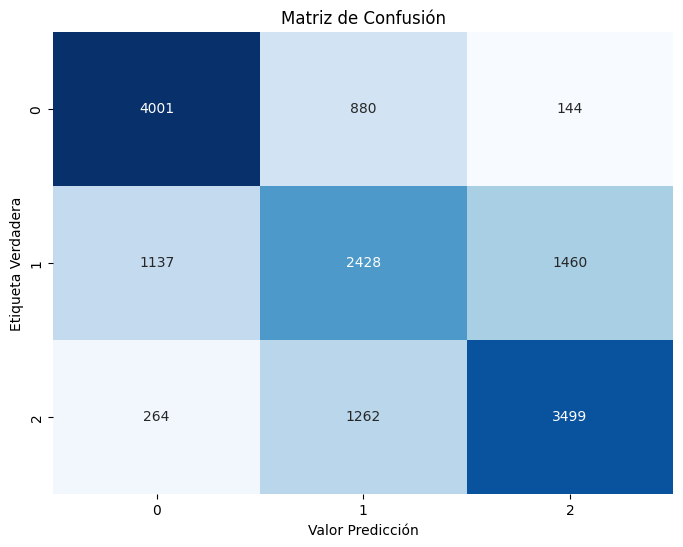

In [37]:
lgbm = LGBMClassifier(max_depth = 10, num_leaves = 40)
lgbm.fit(X_train[selected_columns], y_train)

pred_val = lgbm.predict(X_val[selected_columns])
accuracy = accuracy_score(y_val, pred_val)

matriz = confusion_matrix(y_val, pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.xlabel('Valor Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')

plt.show()

Cargamos nuestro submission_format y categorizamos el dataset de test de la misma forma que lo hicimos con el dataset de train anteriormente.

In [ ]:
submission_format = pd.read_csv('https://raw.githubusercontent.com/JohanSantanaGalvanJob/Modeling-Earthquake-Damage/main/submission_format.csv')
submission_format

In [46]:

df_test['land_surface_condition'] = pd.factorize(df_test['land_surface_condition'])[0]
df_test['foundation_type'] = pd.factorize(df_test['foundation_type'])[0]
df_test['roof_type'] = pd.factorize(df_test['roof_type'])[0]
df_test['ground_floor_type'] = pd.factorize(df_test['ground_floor_type'])[0]
df_test['other_floor_type'] = pd.factorize(df_test['other_floor_type'])[0]
df_test['position'] = pd.factorize(df_test['position'])[0]
df_test['plan_configuration'] = pd.factorize(df_test['plan_configuration'])[0]
df_test['legal_ownership_status'] = pd.factorize(df_test['legal_ownership_status'])[0]

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,0,0,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,0,0,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,0,0,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
submission_format['damage_grade'] = lgbm.predict(df_test[selected_columns])
submission_format['damage_grade'] = submission_format['damage_grade'].astype(int)
submission_format

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [49]:
submission_format.to_csv('SubmitPredictionsEarthquake.csv', index=False)